<a href="https://colab.research.google.com/github/johanwasserman/arealytics/blob/main/arealytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

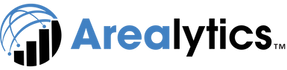


## Test Project  


Entity Relationship Diagram  


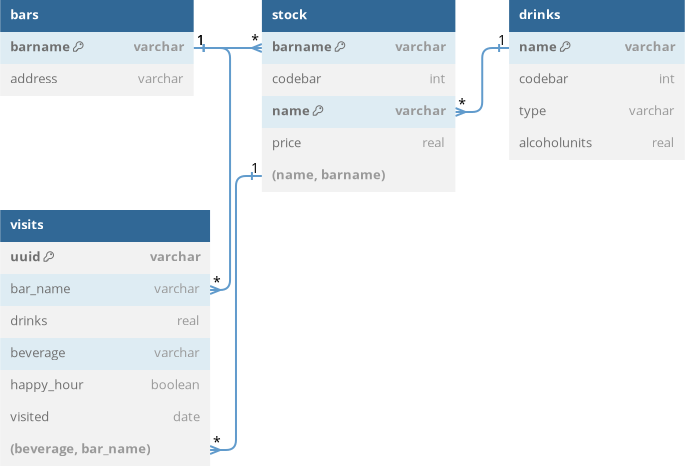

Install Libraries

In [1]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 11.9 MB/s eta 0:00:00


In [2]:
!pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.5 MB/s eta 0:00:00


Imports

In [3]:
import boto3
import botocore
import psycopg2
import pandas as pd
import json
from google.colab import userdata
from psycopg2 import DatabaseError
from psycopg2.extras import execute_values

Variables

In [4]:
bucket_name = 'tests.arealytics.com.au'
prefix = 'data_engineering/test_1/'

db_params = {
  'host': 'arealytics.c4ciivapzwhn.us-west-2.rds.amazonaws.com',
  'dbname': 'postgres',
  'user': 'postgres',
  'password': userdata.get('db_pwd'),
  'port': '5432'
}

Create a session to access AWS S3 bucket

In [5]:
session = boto3.Session()
s3 = session.client('s3', config=botocore.config.Config(signature_version=botocore.UNSIGNED))

#### Normalising Data  
  
For the purpose of this exercise and becasue we have a low data volume, we will process the data in-memory using pandas dataframes.  For production it is suggested to create a staging database in order to process large volumes of data.

In [6]:
def load_s3_file(s3_client: object, file_name: str):
  """
  Loads data from a file in an S3 bucket in to a pandas dataframe.

  Parameters:
  s3_client (obj): The S3 client object to load data from
  file_name (str): The name of the file to load

  Returns:
  pd.DataFrame: a pandas dataframe containing the data
  """
  object_key = prefix + file_name
  response = s3_client.get_object(Bucket=bucket_name, Key=object_key)
  content = response['Body']
  json_str = content.read().decode('utf-8')
  df = pd.read_json(json_str)
  return df

In [7]:
# Visits
visits = load_s3_file(s3, 'visit_events.json')

for column in visits.select_dtypes(include=['float', 'int']):
    visits[column] = visits[column].fillna(0)

We need to convert the happy_hour column to a boolean

In [8]:
visits['happy_hour'] = visits['happy_hour'].astype(bool)
visits.head(2)

,uuid,bar_name,drinks,beverage,happy_hour,visited
0,b7fa5487-831b-445e-a3ec-b08a2b2f9f15,Tiger's Milk,5.0,Tiger's Milk Lager,False,2018-04-19
1,76058cf8-8f01-461d-ab3b-6407687c58a8,Cubana,3.0,Jose Cuervo,False,2019-05-22


In [9]:
# Drinks: a table of alcoholic beverages and their alcohol units.
drinks = load_s3_file(s3, 'beers.json')

Analysis show that there is no entry for Tiger's Milk Lager.  We should request our data collection agents to call the Tigers Milk bar, but since we can infer that Tiger's Milk Lager is a beer, we will create an entry based on our assumption.  

In [10]:
# For production purposes we should have an "updates" folder where data collection agents can save additional or updated data
drinks_update = [
                  { "name": "Tiger's Milk Lager", "codebar": "123456789", "type": "beer", "alcoholUnits": 1.2 }
                ]

drinks = pd.concat([drinks, pd.DataFrame(drinks_update)], ignore_index=True).drop_duplicates(subset='name')
# Set column names to lowercase
drinks.columns = drinks.columns.str.lower()
drinks.head(2)

,name,codebar,type,alcoholunits
0,Corona,65473829,beer,1.2
1,Castle Lite,76531005,beer,1.2


Analysis have shown that the bars.json file not only contains the bars and their addresses, but also the stock (drinks available at the bar).  We need to split stock in to a seperate table.

In [11]:
json_bars = []
json_stock = []

for index, row in load_s3_file(s3, 'bars.json').iterrows():
  bar_name = row['barName']
  bar_addr = row['address']

  json_bars.append({'barname': bar_name, 'address': bar_addr})

  # Process each stock item
  for item in row['stock']:
      json_stock.append({'barname': bar_name, **item})

bars   = pd.DataFrame(json_bars)
stock  = pd.DataFrame(json_stock)

Incorporate the codebar column from the drinks table in to the stock items

In [12]:
stock = pd.merge(stock, drinks[['name', 'codebar']], on='name', how='left')

In [13]:
bars.head(2)

,barname,address
0,Tiger's Milk,"55 Kloof St, Gardens, Cape Town, 8001"
1,Cubana,"Centre, 9 Somerset Rd, Green Point, Cape Town,..."


In [14]:
stock.head(2)

,barname,name,price,codebar
0,Tiger's Milk,Castle Lite,20.0,76531005
1,Tiger's Milk,Jose Cuervo,40.0,24199034


#### Prepare the databse

In [15]:
def db_conn(host, dbname, user, password, port=5432):
    """
    Create and return a connection to a PostgreSQL database.

    Parameters:
    host (str): Database host address
    dbname (str): Database name
    user (str): Username
    password (str): Password
    port (int): Port number, default is 5432

    Returns:
    psycopg2.connection: PostgreSQL database connection object
    """
    try:
        # Establish a connection to the database
        conn = psycopg2.connect(
            host=host,
            dbname=dbname,
            user=user,
            password=password,
            port=port
        )
        print("Database connection established.")
        return conn

    except DatabaseError as e:
        print(f"Database connection failed: {e}")
        return None

In [16]:
def create_db_objects(conn):
    commands = [
        """
        CREATE TABLE IF NOT EXISTS "bars" (
            "barname" varchar PRIMARY KEY,
            "address" varchar
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS "stock" (
            "barname" varchar,
            "codebar" int,
            "name" varchar,
            "price" real,
            PRIMARY KEY ("name", "barname")
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS "drinks" (
            "name" varchar PRIMARY KEY,
            "codebar" int,
            "type" varchar,
            "alcoholunits" real
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS "visits" (
            "uuid" varchar PRIMARY KEY,
            "bar_name" varchar,
            "drinks" real,
            "beverage" varchar,
            "happy_hour" boolean,
            "visited" date
        );
        """
    ]

    with conn.cursor() as cur:
        for command in commands:
            cur.execute(command)

        # Create unique index on stock if it doesn't exist
        cur.execute("""
            SELECT 1 FROM pg_indexes WHERE tablename = 'stock' AND indexname = 'stock_name_barname_idx';
        """)
        if cur.rowcount == 0:
            cur.execute("CREATE UNIQUE INDEX stock_name_barname_idx ON stock (name, barname);")

        # Add foreign key constraints if they don't exist
        cur.execute("""
            SELECT 1 FROM pg_constraint WHERE conname = 'stock_barname_fkey';
        """)
        if cur.rowcount == 0:
            cur.execute("ALTER TABLE stock ADD CONSTRAINT stock_barname_fkey FOREIGN KEY (barname) REFERENCES bars (barname);")

        cur.execute("""
            SELECT 1 FROM pg_constraint WHERE conname = 'stock_codebar_fkey';
        """)
        if cur.rowcount == 0:
            cur.execute("ALTER TABLE stock ADD CONSTRAINT stock_codebar_fkey FOREIGN KEY (name) REFERENCES drinks (name);")

        cur.execute("""
            SELECT 1 FROM pg_constraint WHERE conname = 'visits_barname_fkey';
        """)
        if cur.rowcount == 0:
            cur.execute("ALTER TABLE visits ADD CONSTRAINT visits_barname_fkey FOREIGN KEY (bar_name) REFERENCES bars (barname);")

        cur.execute("""
            SELECT 1 FROM pg_constraint WHERE conname = 'visits_beverage_barname_fkey';
        """)
        if cur.rowcount == 0:
            cur.execute("ALTER TABLE visits ADD CONSTRAINT visits_beverage_barname_fkey FOREIGN KEY (beverage, bar_name) REFERENCES stock (name, barname);")

        conn.commit()


In [17]:
# Connect to the database and create tables, indexes, and constraints
try:
    conn = db_conn(**db_params)
    create_db_objects(conn)
    print("Database setup completed successfully.")
except psycopg2.Error as e:
    print(f"An error occurred: {e}")
finally:
    if conn:
        conn.close()

Database connection established.
Database setup completed successfully.


#### Load the data

In [18]:
# Need to use chunking for larger data volumes
def upsert_df_to_db(df, table_name, unique_key, conn):
    """
    Upsert data from a pandas DataFrame into an existing PostgreSQL table.

    Parameters:
    df (pandas.DataFrame): The DataFrame to load.
    table_name (str): The name of the target PostgreSQL table.
    unique_key (str or list): The unique key column(s) for the ON CONFLICT clause.
    conn (psycopg2.connection): Active PostgreSQL database connection.
    """
    # Create a cursor object
    cur = conn.cursor()

    # Prepare the data to fit the PostgreSQL INSERT statement
    df_columns = list(df)
    columns = ",".join(df_columns)
    placeholders = ",".join(["%s" for _ in df_columns])
    on_conflict = f"ON CONFLICT ({', '.join(unique_key) if isinstance(unique_key, list) else unique_key}) DO UPDATE SET "
    update_columns = ", ".join([f"{col} = EXCLUDED.{col}" for col in df_columns if col not in unique_key])
    upsert_stmt = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders}) {on_conflict} {update_columns}"

    # Execute the upsert for each row in the DataFrame
    for row in df.itertuples(index=False, name=None):
        cur.execute(upsert_stmt, row)

    # Commit the transaction and close the cursor
    conn.commit()
    cur.close()

In [19]:
# Load the data from the dataframes in to their respective Postgres tables
try:
    conn = db_conn(**db_params)
    load_tables = [
      {'df': bars,   'table_name': 'bars',   'unique_key': 'barname', 'conn': conn},
      {'df': drinks, 'table_name': 'drinks', 'unique_key': 'name', 'conn': conn},
      {'df': stock , 'table_name': 'stock',  'unique_key': ['barname', 'name'], 'conn': conn},
      {'df': visits, 'table_name': 'visits', 'unique_key': 'uuid', 'conn': conn}
    ]
    for table in load_tables:
      upsert_df_to_db(**table)
      print(f"Data for table {table['table_name']} loaded successfully.")

except psycopg2.Error as e:
    print(f"An error occurred: {e}")
finally:
    if conn:
        conn.close()

Database connection established.
Data for table bars loaded successfully.
Data for table drinks loaded successfully.
Data for table stock loaded successfully.
Data for table visits loaded successfully.


#### Juan's Drinking Habits

In [20]:
# Helper to query the database
def query(query_string):
  conn = db_conn(**db_params)
  cur = conn.cursor()

  # Execute the query
  cur.execute(query_string)

  # Fetch all the matching rows
  results = cur.fetchall()

  # Close the cursor and the connection
  cur.close()
  conn.close()

  return results

----
1. What is the beverage type that Juan drinks the most?

In [21]:
results = query("""
  SELECT d.type, SUM(v.drinks) as total_consumption
  FROM visits v
  JOIN stock s ON v.beverage = s.name
  JOIN drinks d ON s.name = d.name
  GROUP BY d.type
  ORDER BY total_consumption DESC
  LIMIT 1;
  """)

print(f'The beverage Juan drank the most is {results[0][0]}, of which he had {int(results[0][1])} helpings in total')

Database connection established.
The beverage Juan drank the most is beer, of which he had 5880 helpings in total


----
2. What is the bar Juan visits the most?

In [22]:
results = query("""
SELECT bar_name, COUNT(*) AS total_visits
FROM visits
GROUP BY bar_name
ORDER BY total_visits DESC
LIMIT 1;
""")

print(f"The bar Juan visited most is {results[0][0]}, which he visited {results[0][1]} times.")

Database connection established.
The bar Juan visited most is Yours Truly, which he visited 207 times.


----
3. What is Juan’s favorite beer brand?

In [23]:
results = query("""
SELECT d.name AS beer_brand, SUM(v.drinks) AS total_consumption
FROM visits v
JOIN stock s ON v.beverage = s.name
JOIN drinks d ON s.name = d.name AND d.type = 'beer'
GROUP BY d.name
ORDER BY total_consumption DESC
LIMIT 1;
""")

print(f"Juan's favorite beer brand is {results[0][0]}, of which he enjoyed {int(results[0][1])} helpings.")

Database connection established.
Juan's favorite beer brand is Castle Lite, of which he enjoyed 3770 helpings.


----
4. How many times Juan visited a bar and didn’t have a drink?

In [24]:
# Considering that there could be more than one visited record per bar per day
# include only records where the sum of all records for a bar on any given day
# is 0
results = query("""
SELECT COUNT(*) AS total_visits_no_drinks
FROM (
    SELECT bar_name, visited
    FROM visits
    GROUP BY bar_name, visited
    HAVING SUM(COALESCE(drinks, 0)) = 0
) AS no_drink_visits;
""")

print(f'Juan visited bars without having any drinks {results[0][0]} times')

Database connection established.
Juan visited bars without having any drinks 74 times


----
5. Based on the alcohol units and the amount of drinks consumed, how many times has Juan been drunk in the last month?

In [56]:
# Considering today's date and that the data only contains records up to
# 2019-9-25, we asume "last month" meaning the last month of available data
results = query("""
WITH LatestDate AS (
    SELECT MAX(visited) AS last_visit_date
    FROM visits
),
TotalAlcoholConsumed AS (
    SELECT v.visited, SUM(d.alcoholunits * v.drinks) AS total_alcohol_units
    FROM visits v
    JOIN drinks d ON v.beverage = d.name
    WHERE v.visited BETWEEN (SELECT last_visit_date - INTERVAL '1 month' FROM LatestDate) AND (SELECT last_visit_date FROM LatestDate)
    GROUP BY v.visited
)
SELECT COUNT(*)
FROM TotalAlcoholConsumed
WHERE total_alcohol_units >= 14;
""")

print(f'Juan have been drunk {results[0][0]} times in the last month of the period covered by the data')

Database connection established.
Juan have been drunk 1 times in the last month of the period covered by the data


----
6. The National Health Service (NHS) recommends drinking no more than 14 units of alcohol per week. Based on the previous statement, is Juan an alcoholic?

In [64]:
results = query("""
WITH LatestDate AS (
    SELECT MAX(visited) AS last_visit_date
    FROM visits
),
WeeklyAlcoholConsumption AS (
    SELECT
        DATE_TRUNC('week', v.visited) AS week_start_date,
        SUM(d.alcoholunits * v.drinks) AS total_alcohol_units
    FROM visits v
    JOIN drinks d ON v.beverage = d.name
    WHERE v.visited BETWEEN (SELECT last_visit_date - INTERVAL '1 month' FROM LatestDate) AND (SELECT last_visit_date FROM LatestDate)
    GROUP BY DATE_TRUNC('week', v.visited)
)
SELECT week_start_date, total_alcohol_units
FROM WeeklyAlcoholConsumption
ORDER BY week_start_date;
""")

print('Assuming that consuming more than 14 units of alcohol per week makes you an alcoholic, and considering the following data, Juan is most definately an alcoholic.')
pd.DataFrame(results, columns=['week_start_date', 'total_alcohol_units'])

Database connection established.
Assuming that consuming more than 14 units of alcohol per week makes you an alcoholic, and considering the following data, Juan is most definately an alcoholic.


,week_start_date,total_alcohol_units
0,2019-08-19 00:00:00+00:00,19.199999
1,2019-08-26 00:00:00+00:00,32.200000
2,2019-09-02 00:00:00+00:00,34.800000
3,2019-09-09 00:00:00+00:00,46.000004
4,2019-09-16 00:00:00+00:00,19.800000


----
7. How much money has Juan saved by drinking on Happy Hours?

In [72]:
results = query("""
SELECT SUM(
        CASE
            WHEN v.happy_hour THEN (s.price / 2) * v.drinks
            ELSE 0
        END
    ) AS total_savings
FROM visits v
JOIN stock s ON v.beverage = s.name;
""")

print(f"Juan saved {round(results[0][0], 2)} by drinking during happy hours. He can definately afford to employ me.")

Database connection established.
Juan saved 82986.17 by drinking during happy hours. He can definately afford to employ me.


----
8. Is your transactional model respecting the first, second and third normal form (NF)?

__First Normal Form (1NF)__  
- Each table (bars, stock, drinks, visits) have columns with atomic values.
- There aren't any repeating groups or arrays.
- Primary keys (barname in bars, (barname, name) in stock, name in drinks, uuid in visits) ensure each row is unique.

__Second Normal Form (2NF)__  
- It is in 1NF
- All non-key attributes in each table depend only on the entire primary key and not on a part of it, therefore the tables should meet the 2NF criteria.

__Third Normal Form (3NF)__
- It is in 2NF.
- Attributes in each table depend only on the primary key and not on other non-key attributes.


----
9. If we want to improve the data architecture for analytical purposes what kind of changes would you make to your model?

Improving a data architecture for analytical purposes often involves optimizing for efficient querying, data aggregation, and reporting. Depending on the specific analytical needs and the scale of the data, consider the following changes:  

_**Introduce a Data Warehouse:**_

Data warehouses use a different schema design, typically a star or snowflake schema, optimized for querying large datasets.
Move from OLTP (Online Transaction Processing) focused design in operational databases to an OLAP (Online Analytical Processing) focused design in a data warehouse.
Implement ETL (Extract, Transform, Load) processes to transfer data to the data warehouse.

_**Denormalization:**_

While normalization is great for transactional integrity, denormalization can reduce the number of joins needed for queries, which can be beneficial for analytical queries.
Create aggregated tables that pre-calculate sums, averages, etc., for quick access.

_**Use of Materialized Views:**_

Materialized views store the result of a query physically, so complex aggregations are only calculated once and then retrieved quickly.
They are especially useful for queries that are run frequently and don't require real-time data.

_**Columnar Storage:**_

Consider using a columnar database or a columnar storage format for analytical queries. This can significantly improve query performance over large datasets.
Systems like Amazon Redshift or Google BigQuery are optimized for such use cases.

_**Indexing Strategy:**_

Implement a more robust indexing strategy to speed up query execution, especially for large tables.
Consider bitmap indexes for columns with low cardinality, which are often used in analytics.

_**Partitioning of Large Tables:**_

Partition large tables based on certain criteria (like date) to improve query performance.
Partitioning can help manage large tables by breaking them into smaller, more manageable pieces.

_**Implement a Data Lake (if applicable):**_

For unstructured or semi-structured data, consider a data lake.
Data lakes are suitable for storing large amounts of raw data, which can then be processed and moved into a data warehouse for analysis.

_**Use Business Intelligence Tools:**_

Integrate with Business Intelligence (BI) tools for better data visualization and reporting capabilities.
Tools like Tableau, Power BI, or Looker can connect directly to your database or data warehouse.

_**Data Governance and Quality:**_

Establish robust data governance and data quality measures to ensure the data is accurate, consistent, and reliable.

_**Scalability Considerations:**_

Design for scalability, especially if you expect a significant increase in data volume or query complexity.

  
Each of these changes comes with its trade-offs in terms of complexity, cost, and maintenance overhead. The best approach depends on the specific use case, data volume, and the queries that need to run.

----
10. Is this new proposal respecting the normal forms?

The proposed changes might not strictly respect all normal forms, especially 2NF, 3NF, and BCNF, this deviation is often acceptable and intentional in OLAP systems. The goal in these systems is to optimize for read-heavy workloads, complex queries, and large-scale data analysis, where normalization can sometimes be a hindrance rather than a benefit.
